In [ ]:
# recordings 디렉토리 생성 및 전체 다운로드
!mkdir -p recordings
!wget -q https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.zip
!unzip -q master.zip "free-spoken-digit-dataset-master/recordings/*" -d .
!mv free-spoken-digit-dataset-master/recordings/* recordings/
!rm -rf free-spoken-digit-dataset-master master.zip

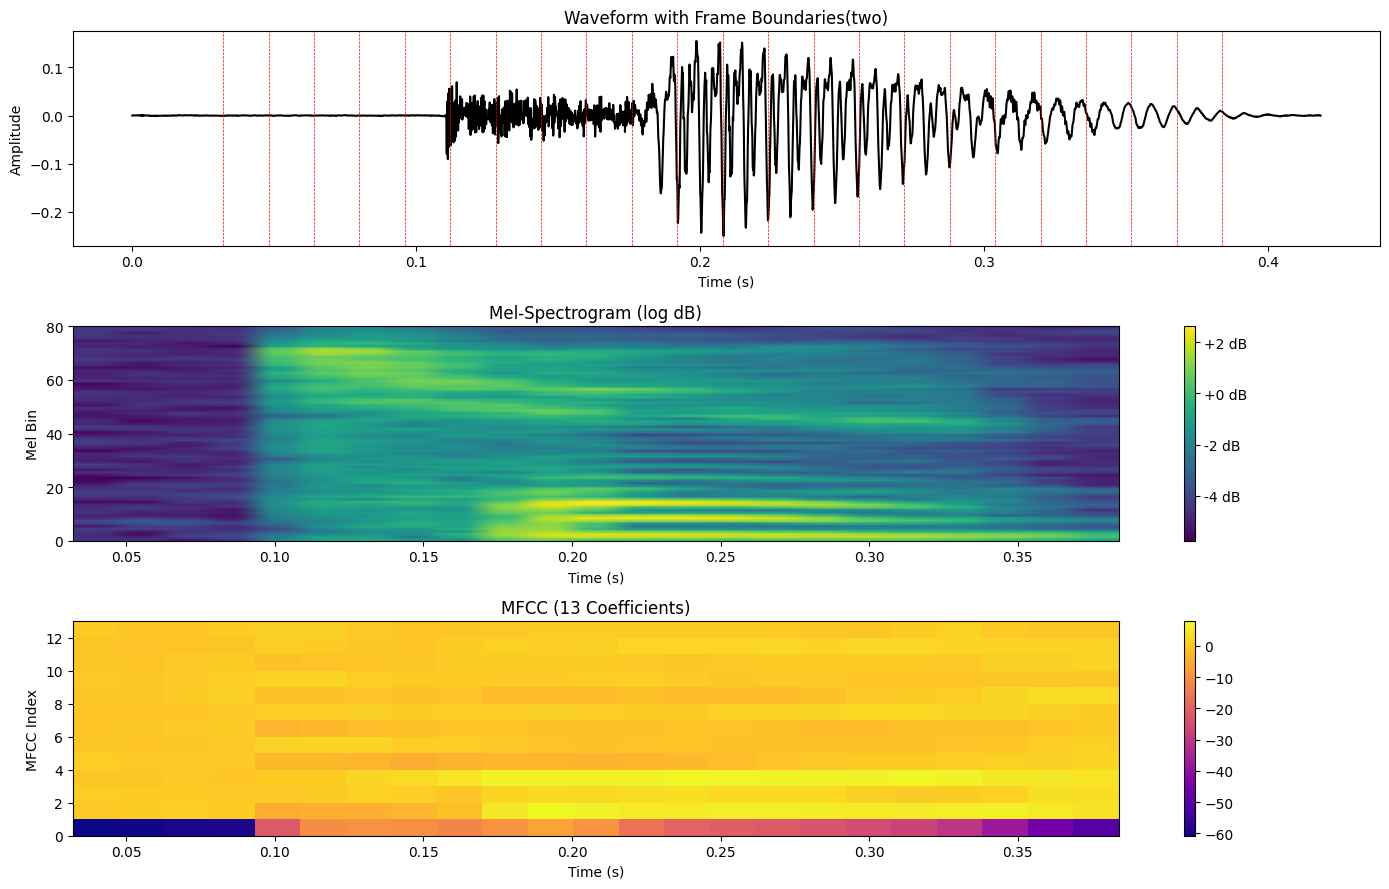

In [ ]:
# 음성 처리와 모델링에 필요한 라이브러리 불러오기
import tensorflow as tf                 # TensorFlow: 신호 처리 및 특성 추출
import matplotlib.pyplot as plt         # matplotlib: 그래프 시각화 도구
import soundfile as sf                  # soundfile: WAV 오디오 파일 읽기용
import numpy as np                      # numpy: 수치 연산 처리
import os                               # os: 파일 시스템 접근 (디렉토리, 파일)
from IPython.display import Audio       # IPython: 오디오 재생용 함수 (Colab/Jupyter 지원)

# 1. recordings 디렉토리에서 .wav 파일 리스트를 정렬하여 첫 번째 파일 선택
file_list = sorted([f for f in os.listdir("recordings") if f.endswith(".wav")])  # .wav 파일만 필터링
file_path = os.path.join("recordings", file_list[701])  # 첫 번째 .wav 파일의 전체 경로 설정

# 2. 오디오 파일 로딩
# waveform: 오디오 신호 (numpy 배열), sr: 샘플링 주파수 (보통 8000Hz)
waveform, sr = sf.read(file_path)

# TensorFlow 처리를 위해 waveform을 float32 형식의 텐서로 변환
waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)

# 3. 오디오 재생 (Colab 또는 Jupyter 환경에서 청취 가능)
# waveform.numpy(): float32 numpy 배열로 변환, rate=sr: 재생 속도
display(Audio(waveform.numpy(), rate=sr))

# 4. STFT(Short-Time Fourier Transform)를 위한 파라미터 설정
frame_length = 512     # 한 프레임당 샘플 수 (약 64ms @8000Hz)
frame_step = 128       # 프레임 이동 거리 (약 16ms)

# 5. STFT 수행 → 복소수 스펙트럼 반환
# 각 프레임의 주파수 분석을 위한 퓨리에 변환 수행
stft = tf.signal.stft(
    waveform,                    # 입력 오디오 신호
    frame_length=frame_length,   # 한 프레임 길이
    frame_step=frame_step,       # 프레임 간 이동 거리
    fft_length=512               # FFT 길이 (Zero-padding 포함)
)

# STFT 결과에서 복소수의 크기(절댓값)만 추출 → 스펙트럼 에너지
magnitude = tf.abs(stft)  # shape: [frames, freq_bins]

# 6. Mel 필터뱅크 정의 및 적용
num_mel_bins = 80  # 출력 mel 필터 수

# FFT 결과를 Mel 스케일로 변환하기 위한 가중치 행렬 생성
mel_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=num_mel_bins,                 # Mel 스케일로 투영할 bin 수
    num_spectrogram_bins=magnitude.shape[-1],  # 입력 스펙트럼 bin 수
    sample_rate=sr,                            # 샘플링 주파수
    lower_edge_hertz=80.0,                     # Mel 스케일 하한
    upper_edge_hertz=sr / 2                    # Mel 스케일 상한 (Nyquist 주파수)
)

# magnitude 스펙트럼에 Mel 가중치 행렬을 곱하여 Mel-spectrogram 생성
mel_spec = tf.matmul(magnitude, mel_matrix)  # shape: [frames, mel_bins]

# 7. log-Mel 변환
# log 스케일은 에너지 차이를 강조하고 log(0) 오류 방지를 위해 1e-6 더함
log_mel = tf.math.log(mel_spec + 1e-6)  # shape: [frames, mel_bins]

# 8. MFCC(Mel-Frequency Cepstral Coefficients) 계산
# log-mel 스펙트럼에 DCT(Discrete Cosine Transform)를 적용하여 13차 계수 추출
mfcc = tf.signal.mfccs_from_log_mel_spectrograms(log_mel)[..., :13]  # shape: [frames, 13]

# 9. 시간축 계산
num_frames = log_mel.shape[0]           # 전체 프레임 수
signal_length = waveform.shape[0]       # 오디오 샘플 수
duration = signal_length / sr           # 전체 오디오 길이 (초)

# waveform 시각화를 위한 시간 벡터 생성 (초 단위)
t_wave = np.linspace(0, duration, signal_length)

# 각 프레임의 중앙 위치를 시간 단위로 계산 (초 단위)
frame_times = (np.arange(num_frames) * frame_step + frame_length // 2) / sr

# 10. 시각화 시작
plt.figure(figsize=(14, 9))  # 전체 출력 그림 크기 설정 (가로 x 세로)

# (1) Waveform 시각화
plt.subplot(3, 1, 1)  # 3행 1열 중 첫 번째 플롯
plt.plot(t_wave, waveform.numpy(), color='black')  # 시간-진폭 파형
# 프레임 경계(중심 시간)에 빨간 점선 표시
for t in frame_times:
    plt.axvline(x=t, color='red', linestyle='--', linewidth=0.5)
plt.title("Waveform with Frame Boundaries(two)")  # 그래프 제목
plt.xlabel("Time (s)")                       # x축: 시간
plt.ylabel("Amplitude")                      # y축: 진폭

# (2) Mel-Spectrogram 시각화
plt.subplot(3, 1, 2)
# 시간축: frame_times 기준, y축: mel bin (0~80)
plt.imshow(
    log_mel.numpy().T,                       # [mel, time] 형태로 전치
    aspect='auto',                           # 축 비율 자동 조정
    origin='lower',                          # y축 방향 아래→위
    cmap='viridis',                          # 색상 스타일
    extent=[frame_times[0], frame_times[-1], 0, num_mel_bins]  # 시간축 위치 조정
)
plt.title("Mel-Spectrogram (log dB)")
plt.xlabel("Time (s)")
plt.ylabel("Mel Bin")
plt.colorbar(format="%+2.0f dB")            # 오른쪽 컬러바

# (3) MFCC 시각화
plt.subplot(3, 1, 3)
plt.imshow(
    mfcc.numpy().T,                          # [mfcc, time] 전치
    aspect='auto',
    origin='lower',
    cmap='plasma',
    extent=[frame_times[0], frame_times[-1], 0, 13]  # y축: MFCC 계수 (0~12)
)
plt.title("MFCC (13 Coefficients)")
plt.xlabel("Time (s)")
plt.ylabel("MFCC Index")
plt.colorbar()                              # 오른쪽 컬러바

# 전체 서브플롯 간 간격 조정
plt.tight_layout()

# 화면에 출력
plt.show()

Backend 실습

Cloning into 'free-spoken-digit-dataset'...
remote: Enumerating objects: 4260, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 4260 (delta 25), reused 8 (delta 8), pack-reused 4212 (from 1)
Receiving objects: 100% (4260/4260), 30.38 MiB | 22.35 MiB/s, done.
Resolving deltas: 100% (129/129), done.
Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 0.1181 - loss: 2.3687 - val_accuracy: 0.2133 - val_loss: 2.1995
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.1852 - loss: 2.1854 - val_accuracy: 0.2933 - val_loss: 1.9285
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 0.3065 - loss: 1.8185 - val_accuracy: 0.4667 - val_loss: 1.4384
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.4748 - loss: 1.4691 - val_accuracy: 0.5483 - val_loss: 1.2471
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.5381 - loss: 1.2736 - val_accuracy: 0.6183 - val_los

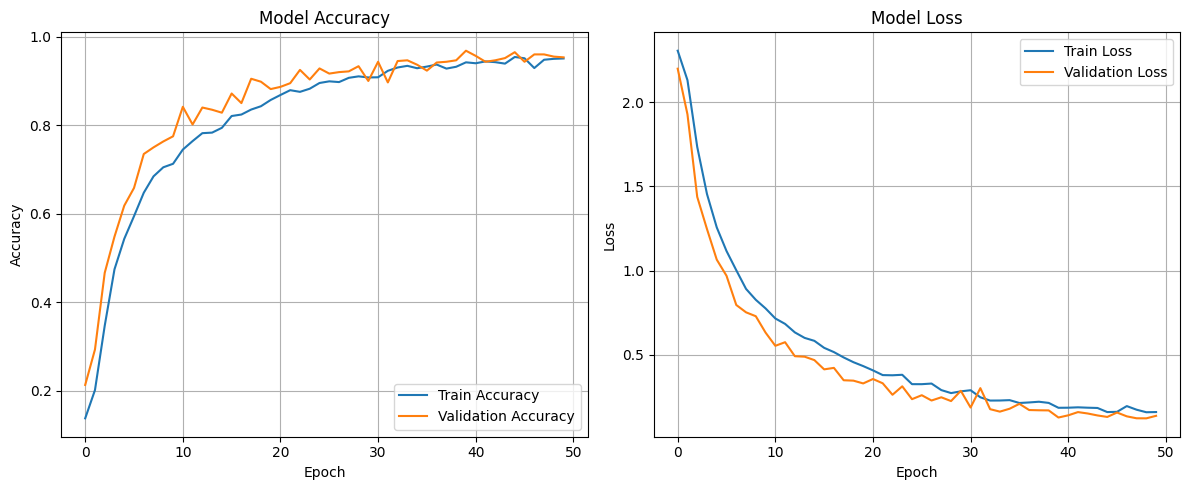

In [ ]:
# 1. 필요한 라이브러리 설치
!pip install librosa --quiet

# 2. 데이터 다운로드 (FSDD)
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git
!mv free-spoken-digit-dataset/recordings recordings


# 3. 전체 코드
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Layer, Dense, Dropout, LayerNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# 커스텀 레이어 정의 -> 커스텀 block보다는 transorflow기본 블록으로 블록정의를 하는 것을 추천
@tf.keras.utils.register_keras_serializable()
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_emb = Dense(embed_dim)
        self.pos_emb = self.add_weight(name="pos_emb", shape=(maxlen, embed_dim), initializer="uniform")
        self.maxlen = maxlen
        self.embed_dim = embed_dim

    def call(self, x):
        maxlen = tf.shape(x)[1]
        x = self.token_emb(x)
        return x + self.pos_emb[:maxlen]

    def get_config(self):
        config = super().get_config()
        config.update({
            "maxlen": self.maxlen,
            "embed_dim": self.embed_dim
        })
        return config

@tf.keras.utils.register_keras_serializable()
class TransformerBlock(Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(dff, activation="relu"),
            Dense(d_model)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.dropout_rate = dropout_rate

    def call(self, x, training=False):
        attn_output = self.att(x, x)
        out1 = self.layernorm1(x + self.dropout1(attn_output, training=training))
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + self.dropout2(ffn_output, training=training))

    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "dff": self.dff,
            "dropout_rate": self.dropout_rate
        })
        return config

# 데이터 로딩 -> sampling rate 16kHz로 하여 sampling하고 mel-filter에서 bank의 개수를 13개로 하여 MFCC를 출력한다.
def load_fsdd(path, max_len=100):
    X, y = [], []
    for file in os.listdir(path):
        if file.endswith(".wav"):
            label = int(file.split("_")[0])
            wav, sr = librosa.load(os.path.join(path, file), sr=16000)
            mfcc = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=13)
            if mfcc.shape[1] < max_len:
                pad_width = max_len - mfcc.shape[1]
                mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
            else:
                mfcc = mfcc[:, :max_len]
            X.append(mfcc.T)
            y.append(label)
    X = np.array(X)
    y = to_categorical(np.array(y), num_classes=10)
    return X, y

# 모델 생성
def build_model(maxlen=100, n_mfcc=13, embed_dim=64, num_heads=4, ff_dim=128):
    inputs = Input(shape=(maxlen, n_mfcc))
    x = TokenAndPositionEmbedding(maxlen, embed_dim)(inputs)#여기서부터
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)#여기까지가 커스텀 block이다.
    x = GlobalAveragePooling1D()(x)#data들의 대표특징만 남기고 나머지는 제거한다.
    x = Dropout(0.1)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.1)(x)
    outputs = Dense(10, activation="softmax")(x)
    model = Model(inputs, outputs)
    model.compile(loss="categorical_crossentropy", optimizer=Adam(1e-4), metrics=["accuracy"])
    return model


import matplotlib.pyplot as plt

# 학습 및 저장
X, y = load_fsdd("recordings")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = build_model()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test)) #실제 학습
model.save("fsdd_transformer_final.keras")

# 시각화: 정확도와 손실
plt.figure(figsize=(12, 5))

# 1) 정확도
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# 2) 손실
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 5. 추론
def extract_features(path, sample_rate=16000, n_mfcc=13, max_len=100):
    wav, sr = librosa.load(path, sr=sample_rate)
    mfcc = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=n_mfcc)
    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc.T[np.newaxis, :, :]

def predict_digit(model_path, wav_path):
    model = tf.keras.models.load_model(model_path, custom_objects={
        "TokenAndPositionEmbedding": TokenAndPositionEmbedding,
        "TransformerBlock": TransformerBlock
    })
    features = extract_features(wav_path)
    pred = model.predict(features)
    print("예측 결과:", np.argmax(pred), "=> 확률:", np.max(pred))

# 실행

predict_digit("fsdd_transformer_final.keras", "recordings/4_george_0.wav")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'token_and_position_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'transformer_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
예측 결과: 4 => 확률: 0.99453706


Speech Backend(Front 포함)--pytoch기반

In [ ]:
!pip install librosa torchaudio
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git
!mv free-spoken-digit-dataset/recordings recordings

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import os
import torch
import librosa
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class FSDDDataset(Dataset):
    def __init__(self, file_list, max_len=100):
        self.file_list = file_list
        self.max_len = max_len

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        path = self.file_list[idx]
        label = int(os.path.basename(path)[0])
        wav, sr = librosa.load(path, sr=16000)
        mfcc = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=13)
        if mfcc.shape[1] < self.max_len:
            pad = self.max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0,0),(0,pad)), mode='constant')
        else:
            mfcc = mfcc[:, :self.max_len]
        x = torch.tensor(mfcc.T, dtype=torch.float32)
        y = torch.tensor(label, dtype=torch.long)
        return x, y

# 파일 목록 구성
all_files = [os.path.join("recordings", f) for f in os.listdir("recordings") if f.endswith(".wav")]
train_files, test_files = train_test_split(all_files, test_size=0.2, random_state=42)

train_dataset = FSDDDataset(train_files)
test_dataset = FSDDDataset(test_files)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        self.pe = pe.unsqueeze(0)  # [1, max_len, d_model]

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class ASRTransformer(nn.Module):
    def __init__(self, input_dim=13, max_len=100, d_model=64, nhead=4, num_classes=10):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=128, dropout=0.1)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x)          # [B, T, d_model]
        x = self.pos_enc(x)            # [B, T, d_model]
        x = x.transpose(0, 1)          # [T, B, d_model] for transformer
        x = self.transformer(x)        # [T, B, d_model]
        x = x.transpose(0, 1)          # [B, T, d_model]
        x = self.pool(x.transpose(1,2)).squeeze(2)  # [B, d_model]
        return self.classifier(x)

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ASRTransformer().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_loss_list, val_acc_list = [], []

for epoch in range(30):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss_list.append(total_loss / len(train_loader))

    # 검증
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            correct += (pred.argmax(1) == yb).sum().item()
            total += yb.size(0)
    val_acc = correct / total
    val_acc_list.append(val_acc)
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Val Acc = {val_acc:.4f}")

# 모델 저장
torch.save(model.state_dict(), "fsdd_transformer_final.pt")
print('모델저장 완료')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1: Loss = 172.4552, Val Acc = 0.1800
Epoch 2: Loss = 167.7956, Val Acc = 0.2783
Epoch 3: Loss = 154.7216, Val Acc = 0.3167
Epoch 4: Loss = 137.7740, Val Acc = 0.3967
Epoch 5: Loss = 120.1468, Val Acc = 0.4950
Epoch 6: Loss = 103.2853, Val Acc = 0.6533
Epoch 7: Loss = 88.3422, Val Acc = 0.7267
Epoch 8: Loss = 75.0989, Val Acc = 0.7867
Epoch 9: Loss = 62.9519, Val Acc = 0.7700
Epoch 10: Loss = 54.1556, Val Acc = 0.8600
Epoch 11: Loss = 47.3453, Val Acc = 0.8733
Epoch 12: Loss = 40.9202, Val Acc = 0.8900
Epoch 13: Loss = 35.6069, Val Acc = 0.8883
Epoch 14: Loss = 31.1669, Val Acc = 0.8933
Epoch 15: Loss = 27.7893, Val Acc = 0.9233
Epoch 16: Loss = 24.2167, Val Acc = 0.9300
Epoch 17: Loss = 21.1678, Val Acc = 0.9350
Epoch 18: Loss = 18.1955, Val Acc = 0.9250
Epoch 19: Loss = 17.2950, Val Acc = 0.9400
Epoch 20: Loss = 15.6044, Val Acc = 0.9433
Epoch 21: Loss = 14.1764, Val Acc = 0.9400
Epoch 22: Loss = 12.8191, Val Acc = 0.9467
Epoch 23: Loss = 11.8872, Val Acc = 0.9500
Epoch 24: Loss

In [ ]:
#추론
import torch.nn.functional as F

def predict(model_path, wav_path):
    model = ASRTransformer()
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    model.eval()

    wav, sr = librosa.load(wav_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=13)
    if mfcc.shape[1] < 100:
        pad = 100 - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0,0),(0,pad)), mode='constant')
    else:
        mfcc = mfcc[:, :100]
    x = torch.tensor(mfcc.T[np.newaxis, ...], dtype=torch.float32)  # [1, 100, 13]

    with torch.no_grad():
        output = model(x)  # [1, 10]
        prob = F.softmax(output, dim=1)  # 확률로 변환
        pred_class = torch.argmax(prob, dim=1).item()
        pred_confidence = torch.max(prob).item()  # 가장 높은 확률

    print(f"예측 결과: {pred_class} (확률: {pred_confidence:.4f})")

In [ ]:
predict("fsdd_transformer_final.pt", "recordings/4_george_0.wav")

예측 결과: 4 (확률: 0.9868)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


사용자 정의 클래스 없이, TensorFlow 기본 레이어만으로 구성된 순수 트랜스포머 기반 ASR

In [ ]:
!pip install librosa torchaudio
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git
!mv free-spoken-digit-dataset/recordings recordings

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split

def load_fsdd(path, max_len=100):
    X, y = [], []
    for file in os.listdir(path):
        if file.endswith(".wav"):
            label = int(file.split("_")[0])
            wav, sr = librosa.load(os.path.join(path, file), sr=16000)
            mfcc = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=13)
            if mfcc.shape[1] < max_len:
                pad = max_len - mfcc.shape[1]
                mfcc = np.pad(mfcc, ((0, 0), (0, pad)), mode='constant')
            else:
                mfcc = mfcc[:, :max_len]
            X.append(mfcc.T)  # shape: (max_len, 13)
            y.append(label)
    X = np.array(X)
    y = tf.keras.utils.to_categorical(np.array(y), num_classes=10)
    return X, y

In [ ]:
def build_transformer_model(maxlen=100, n_mfcc=13, d_model=64, num_heads=4, dff=128):
    inputs = tf.keras.Input(shape=(maxlen, n_mfcc))

    # 1. 선형 임베딩--여기서부터
    x = tf.keras.layers.Dense(d_model)(inputs)

    # 2. 위치 임베딩 (학습 가능한 방식)
    positions = tf.range(start=0, limit=maxlen, delta=1)
    pos_emb = tf.keras.layers.Embedding(input_dim=maxlen, output_dim=d_model)(positions)
    x += pos_emb

    # 3. Self-Attention
    attn = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    x = tf.keras.layers.Add()([x, attn])
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    # 4. Feed Forward
    ffn = tf.keras.layers.Dense(dff, activation='relu')(x)
    ffn = tf.keras.layers.Dense(d_model)(ffn)
    x = tf.keras.layers.Add()([x, ffn])
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    # 5. 출력층---여기까지 layer이다.
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
X, y = load_fsdd("recordings")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = build_transformer_model()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
model.save("fsdd_transformer_basic.keras")

Epoch 1/50


FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-8-2857043771.py", line 5, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_13464]

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 정확도
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 손실
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def extract_features(path, sample_rate=16000, n_mfcc=13, max_len=100):
    wav, sr = librosa.load(path, sr=sample_rate)
    mfcc = librosa.feature.mfcc(y=wav, sr=sr, n_mfcc=n_mfcc)
    if mfcc.shape[1] < max_len:
        pad = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]
    return mfcc.T[np.newaxis, :, :]

def predict_digit(model_path, wav_path):
    model = tf.keras.models.load_model(model_path)
    features = extract_features(wav_path)
    pred = model.predict(features)
    pred_class = np.argmax(pred)
    confidence = np.max(pred)
    print(f"예측 결과: {pred_class} (확률: {confidence:.4f})")

In [ ]:
# 예측 실행 예시
predict_digit("fsdd_transformer_basic.keras", "recordings/4_george_0.wav")